In [ ]:
# ================================
# PATCHTST FOR RAINFALL PREDICTION
# BINARY CLASSIFICATION (RAIN / NO RAIN)
# Entire pipeline identical to your CNN-LSTM script
# except the model block replaced with PatchTST
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, Add, MultiHeadAttention,
    Flatten, Reshape, Conv1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import GlobalAveragePooling1D

# ===========================================================
# 1. LOAD & FEATURE ENGINEERING   (unchanged)
# ===========================================================

def load_and_prepare_data():
    df_2019 = pd.read_csv(r"C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2019.csv").assign(YEAR=2019)
    df_2020 = pd.read_csv(r"C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2020.csv").assign(YEAR=2020)
    df_2021 = pd.read_csv(r"C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2021.csv").assign(YEAR=2021)
    df_2022 = pd.read_csv(r"C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2022.csv").assign(YEAR=2022)

    full_df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)

    # datetime features
    full_df["datetime"] = pd.to_datetime(dict(
        year=full_df["YEAR"], month=full_df["MO"], day=full_df["DY"]
    ))
    full_df["DOY"] = full_df["datetime"].dt.dayofyear
    full_df["sin_DOY"] = np.sin(2*np.pi * full_df["DOY"]/365.25)
    full_df["cos_DOY"] = np.cos(2*np.pi * full_df["DOY"]/365.25)

    # lagged features
    for lag in [1, 3, 7]:
        full_df[f"PRECTOTCORR_lag{lag}"] = full_df["PRECTOTCORR"].shift(lag)

    # Sea Level Temperature
    full_df["SLT"] = full_df["TS"] + (0.0065 * 505.5)

    full_df.dropna(inplace=True)

    # binary target
    full_df["binary"] = (full_df["PRECTOTCORR"] > 0).astype(int)

    features = [
        "SLT", "SLP", "T2M", "TS", "T2M_MAX", "T2M_MIN",
        "RH2M", "WS10M_MAX", "WS10M_MIN", "sin_DOY", "cos_DOY",
        "PRECTOTCORR_lag1", "PRECTOTCORR_lag3", "PRECTOTCORR_lag7"
    ]

    train_df = full_df[full_df["YEAR"].isin([2019, 2020, 2021])]
    test_df = full_df[full_df["YEAR"] == 2022]

    print("\n=== Data Partition Validation ===")
    print(train_df["binary"].value_counts())
    print(test_df["binary"].value_counts())

    return train_df, test_df, features


# ===========================================================
# 2. SMOTE + SCALING   (unchanged)
# ===========================================================

def preprocess_and_balance_data(train_df, test_df, features):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_df[features])
    X_test = scaler.transform(test_df[features])

    sm = SMOTE(random_state=42)
    X_bal, y_bal = sm.fit_resample(X_train, train_df["binary"])

    train_bal = pd.DataFrame(X_bal, columns=features)
    train_bal["binary"] = y_bal

    test_scaled = pd.DataFrame(X_test, columns=features)
    test_scaled["binary"] = test_df["binary"]
    test_scaled["DOY"] = test_df["DOY"]

    return train_bal, test_scaled, scaler


# ===========================================================
# 3. SEQUENCE GENERATION   (unchanged)
# ===========================================================

def create_sequences(df, features, seq_len):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df[features].iloc[i:i+seq_len].values)
        y.append(df["binary"].iloc[i+seq_len])
    return np.array(X), np.array(y)


# ===========================================================
# 4. PATCHTST MODEL  **(TensorFlow version)**
# ===========================================================

def build_patchtst(seq_len, n_features, patch_size=3, d_model=512, heads=8, ff_dim=1024, layers=8):

    # Input: (batch, seq_len, n_features)
    inp = Input(shape=(seq_len, n_features))

    # 1) Patchify
    num_patches = seq_len // patch_size
    x = Reshape((num_patches, patch_size * n_features))(inp)

    # 2) Linear projection (patch embedding)
    x = Dense(d_model)(x)

    # 3) Positional embedding
    pos_emb = tf.Variable(tf.random.normal([1, num_patches, d_model]), trainable=True)
    x = x + pos_emb

    # 4) Transformer Encoder Blocks
    for _ in range(layers):
        # Multi-head attention
        attn = MultiHeadAttention(num_heads=heads, key_dim=d_model)(x, x)
        x = Add()([x, attn])
        x = LayerNormalization()(x)

        # Feedforward network
        ffn = Dense(ff_dim, activation="relu")(x)
        ffn = Dense(d_model)(ffn)
        x = Add()([x, ffn])
        x = LayerNormalization()(x)

    # 5) Global Average Pooling over patches
    x = GlobalAveragePooling1D()(x)

    # 6) Classifier
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    model.summary()
    return model


# ===========================================================
# 5. TRAIN + EVALUATE  (EarlyStopping + 200 epochs)
# ===========================================================

def train_and_evaluate(seq_len=60):

    train_df, test_df, features = load_and_prepare_data()

    train_bal, test_scaled, scaler = preprocess_and_balance_data(train_df, test_df, features)

    # 🔥 drop NaN caused by lag features
    train_bal.dropna(inplace=True)
    test_scaled.dropna(inplace=True)

    # now safe to create sequences
    X_train, y_train = create_sequences(train_bal, features, seq_len)
    X_test, y_test = create_sequences(test_scaled, features, seq_len)


    print("Train shape:", X_train.shape)
    print("Test shape:", X_test.shape)

    model = build_patchtst(seq_len, len(features))

    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int)

    print("\n=== TEST SET METRICS ===")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("AUC      :", roc_auc_score(y_test, y_prob))

    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    plot_results(history, y_test, y_prob, y_pred)

    return model, scaler, test_scaled, features


# ===========================================================
# 6. PLOTTING (unchanged)
# ===========================================================

def plot_results(history, y_test, y_prob, y_pred):

    # Training curves
    plt.figure(figsize=(14, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Training Loss Curve")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.2f}")
    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()


# ===========================================================
# 7. 7-DAY FORECAST  (unchanged)
# ===========================================================

def make_predictions(model, scaler, test_df, features, seq_len, days=7):

    seq = test_df[features].iloc[-seq_len:].values
    preds = []

    for _ in range(days):
        x = seq.reshape(1, seq_len, len(features))
        prob = model.predict(x)[0][0]
        p = 1 if prob > 0.5 else 0

        preds.append(p)

        new_row = seq[-1].copy()
        new_row[-3] = prob   # update lag1
        seq = np.vstack([seq[1:], new_row])

    return preds


# ===========================================================
# RUN PIPELINE
# ===========================================================

if __name__ == "__main__":
    model, scaler, test_scaled, features = train_and_evaluate()

    print("\n=== 7-DAY RAINFALL FORECAST ===")
    preds = make_predictions(model, scaler, test_scaled, features, seq_len=60)
    for i, p in enumerate(preds, 1):
        print(f"Day {i}: {'Rain' if p==1 else 'No Rain'}")



=== Data Partition Validation ===
binary
1    634
0    455
Name: count, dtype: int64
binary
1    201
0    164
Name: count, dtype: int64
Train shape: (1208, 60, 14)
Test shape: (0,)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 60, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 20, 42)    │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 20, 512)   │     22,016 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, 20, 512)   │          0 │ dense_58[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 512)   │  8,401,408 │ add_52[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_52[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_53 (Add)        │ (None, 20, 512)   │          0 │ add_52[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 512)   │      1,024 │ add_53[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 20, 1024)  │    525,312 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 20, 512)   │    524,800 │ dense_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_54 (Add)        │ (None, 20, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 512)   │      1,024 │ add_54[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 512)   │  8,401,408 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 20, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 512)   │      1,024 │ add_55[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 20, 1024)  │    525,312 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 20, 512)   │    524,800 │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 20, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 512)   │      1,024 │ add_56[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 512)   │  8,401,408 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 75,716,353 (288.83 MB)

 Trainable params: 75,716,353 (288.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
13/31 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - accuracy: 0.5920 - auc_3: 0.5141 - loss: 0.9494 - precision_3: 0.6624 - recall_3: 0.7572

KeyboardInterrupt: 

=== Data Partition Validation ===
Training years: [2019, 2020, 2021]
Testing year:   2022

Training period: 2019-01-08 to 2021-12-31
Testing period:  2022-01-01 to 2022-12-31

Training samples: 1,089
Testing samples:  365

Class distribution (Training):
PRECTOTCORR_binary
1    0.582185
0    0.417815
Name: proportion, dtype: float64

Class distribution (Testing):
PRECTOTCORR_binary
1    0.550685
0    0.449315
Name: proportion, dtype: float64

After SMOTE balancing:
PRECTOTCORR_binary
0    634
1    634
Name: count, dtype: int64

Final input shapes:
X_train: (1253, 15, 14), y_train: (1253,)
X_test:  (350, 15, 14), y_test:  (350,)
Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.7076 - auc_5: 0.7572 - loss: 0.5852 - precision_5: 0.7356 - recall_5: 0.8050 - val_accuracy: 0.8526 - val_auc_5: 0.7987 - val_loss: 0.3788 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.8054 

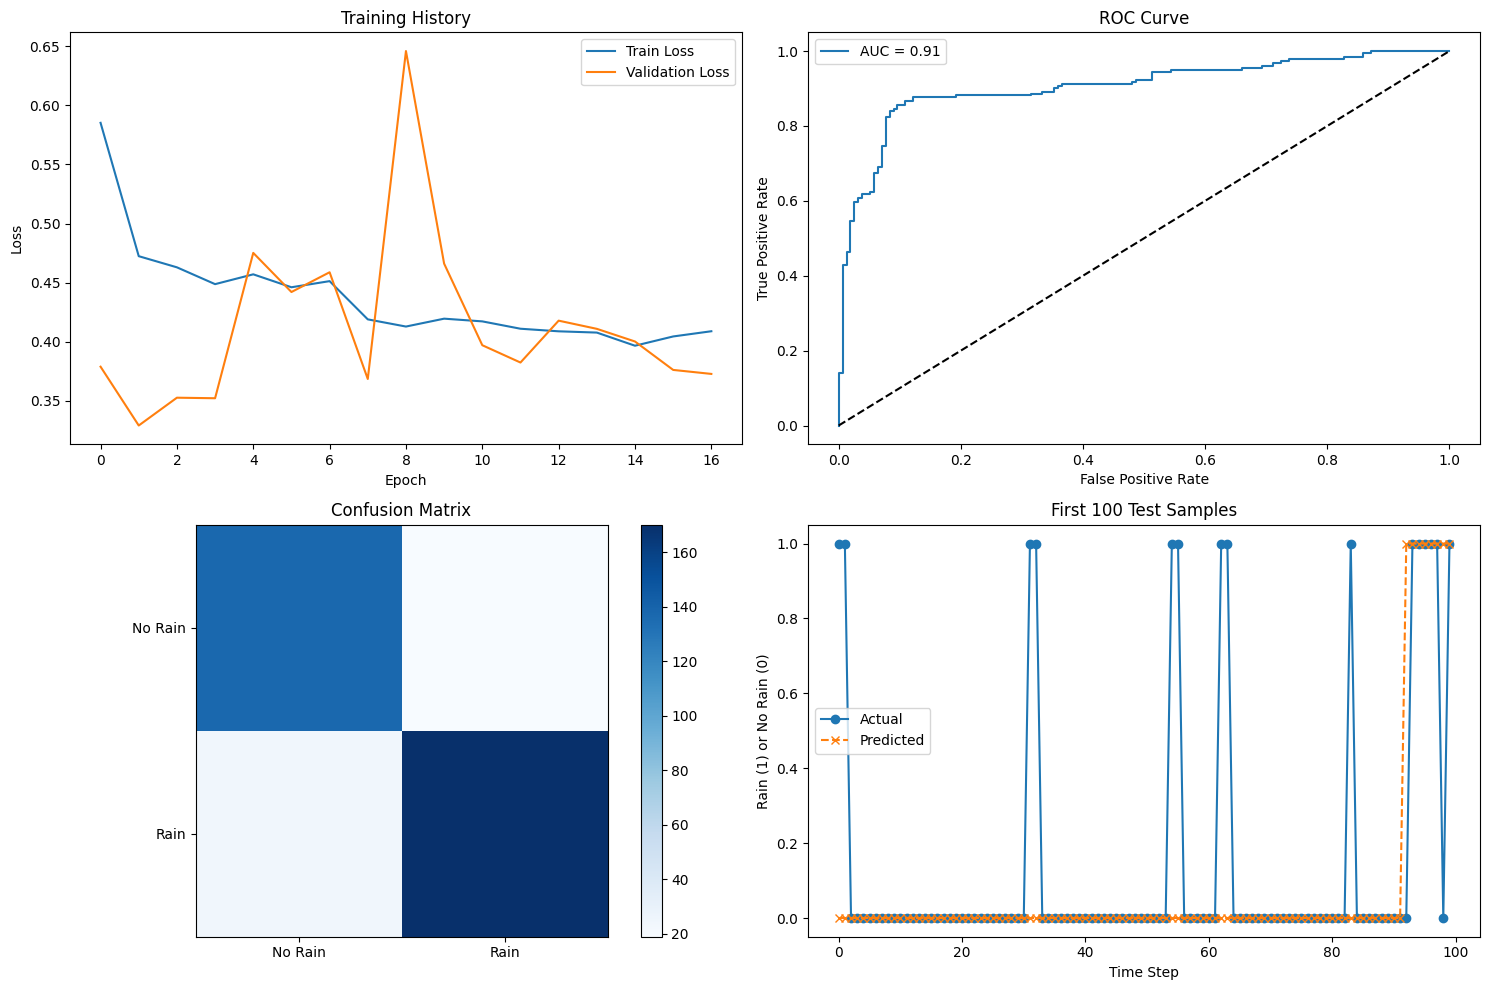


=== 7-Day Rainfall Forecast ===
Day 1: No Rain
Day 2: No Rain
Day 3: No Rain
Day 4: No Rain
Day 5: No Rain
Day 6: No Rain
Day 7: No Rain


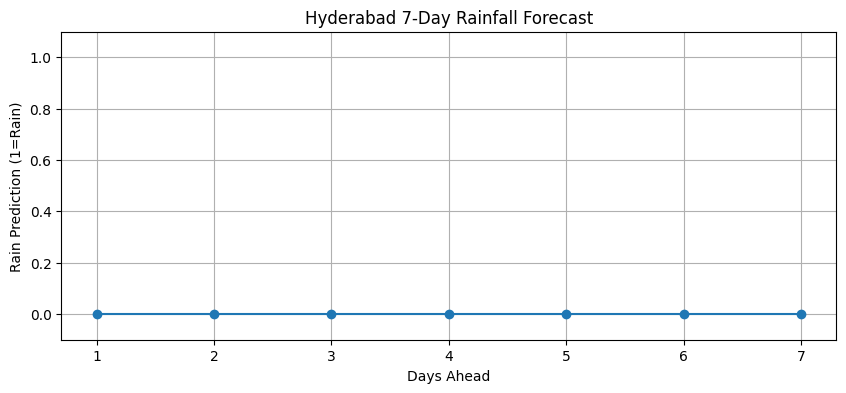

In [8]:
#for rainfaal hyderabad using transformer model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                           accuracy_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling1D
# Modified version with enhanced validation checks

def load_and_prepare_data():
    try:
        # Load individual year datasets with explicit year tagging
         df_2019 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2019.csv').assign(YEAR=2019)
         df_2020 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2020.csv').assign(YEAR=2020)
         df_2021 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2021.csv').assign(YEAR=2021)
         df_2022 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2022.csv').assign(YEAR=2022)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading CSV files: {e}")

    # Combine data while preserving year information
    full_df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)
    
    # Data quality checks
    required_cols = ['YEAR', 'MO', 'DY', 'PRECTOTCORR']
    missing_cols = [col for col in required_cols if col not in full_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Convert and clean data
    for col in required_cols:
        full_df[col] = pd.to_numeric(full_df[col], errors='coerce')
    full_df.dropna(subset=required_cols, inplace=True)

    # Create datetime and derived temporal features
    full_df['datetime'] = pd.to_datetime(dict(year=full_df['YEAR'], 
                                            month=full_df['MO'], 
                                            day=full_df['DY']))
    full_df['DOY'] = full_df['datetime'].dt.dayofyear
    full_df['sin_DOY'] = np.sin(2 * np.pi * full_df['DOY'] / 365.25)
    full_df['cos_DOY'] = np.cos(2 * np.pi * full_df['DOY'] / 365.25)

    # Create lagged precipitation features
    for lag in [1, 3, 7]:
        full_df[f'PRECTOTCORR_lag{lag}'] = full_df['PRECTOTCORR'].shift(lag)

    # Calculate Sea Level Temperature (Adilabad elevation: 254m)
    full_df['SLT'] = full_df['TS'] + (0.0065 * 505.5)
    full_df.dropna(inplace=True)

    # Define final feature set
    features = ['SLT', 'SLP', 'T2M', 'TS', 'T2M_MAX', 'T2M_MIN', 
               'RH2M', 'WS10M_MAX', 'WS10M_MIN',
               'sin_DOY', 'cos_DOY', 
               'PRECTOTCORR_lag1', 'PRECTOTCORR_lag3', 'PRECTOTCORR_lag7']
    target = 'PRECTOTCORR'
    full_df['PRECTOTCORR_binary'] = (full_df[target] > 0).astype(int)

    # Strict year-based splitting with validation
    train_years = [2019, 2020, 2021]
    test_year = 2022
    
    train_df = full_df[full_df['YEAR'].isin(train_years)].copy()
    test_df = full_df[full_df['YEAR'] == test_year].copy()
    
    # Additional validation checks
    if len(train_df) == 0:
        raise ValueError("No training data found for specified years")
    if len(test_df) == 0:
        raise ValueError("No test data found for specified year")
    
    # Check for temporal leakage
    max_train_date = train_df['datetime'].max()
    min_test_date = test_df['datetime'].min()
    if min_test_date <= max_train_date:
        raise ValueError(f"Temporal leakage detected! Latest training date ({max_train_date}) is after earliest test date ({min_test_date})")

    # Validate the split
    print("=== Data Partition Validation ===")
    print(f"Training years: {train_years}")
    print(f"Testing year:   {test_year}")
    print(f"\nTraining period: {train_df['datetime'].min().date()} to {train_df['datetime'].max().date()}")
    print(f"Testing period:  {test_df['datetime'].min().date()} to {test_df['datetime'].max().date()}")
    print(f"\nTraining samples: {len(train_df):,}")
    print(f"Testing samples:  {len(test_df):,}")
    print("\nClass distribution (Training):")
    print(train_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    print("\nClass distribution (Testing):")
    print(test_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    
    return train_df, test_df, features, 'PRECTOTCORR_binary'

# Rest of your code remains the same...
# Step 2: Balance and Scale Data
def preprocess_and_balance_data(train_df, test_df, features, target):
    # Initialize scaler and scale features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[features])
    test_scaled = scaler.transform(test_df[features])

    # Apply SMOTE only to training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(train_scaled, train_df[target])
    
    # Create balanced DataFrames
    train_balanced = pd.DataFrame(X_resampled, columns=features)
    train_balanced[target] = y_resampled
    
    test_processed = pd.DataFrame(test_scaled, columns=features, index=test_df.index)
    test_processed[target] = test_df[target]
    test_processed['DOY'] = test_df['DOY']  # Preserve for sequence generation
    
    print("\nAfter SMOTE balancing:")
    print(train_balanced[target].value_counts())
    
    return train_balanced, test_processed, scaler

# Step 3: Create Time Sequences
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Step 4: Build Patchtst Model
def build_patchtst(seq_len, n_features, patch_size=5, d_model=256, heads=8, ff_dim=512, layers=6):
    
    inp = Input(shape=(seq_len, n_features))

    # Patchify
    num_patches = seq_len // patch_size
    x = Reshape((num_patches, patch_size * n_features))(inp)

    # Patch embedding
    x = Dense(d_model)(x)

    # Positional embedding
    pos_emb = tf.Variable(tf.random.normal([1, num_patches, d_model]), trainable=True)
    x = x + pos_emb

    # Transformer encoder blocks
    for _ in range(layers):
        attn = MultiHeadAttention(num_heads=heads, key_dim=d_model)(x, x)
        x = Add()([x, attn])
        x = LayerNormalization()(x)

        ffn = Dense(ff_dim, activation="relu")(x)
        ffn = Dense(d_model)(ffn)
        x = Add()([x, ffn])
        x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model


# Step 5: Train and Evaluate
def train_and_evaluate(seq_length=30):
    # Load and prepare data
    train_df, test_df, features, target = load_and_prepare_data()
    
    # Preprocess and balance
    train_balanced, test_processed, scaler = preprocess_and_balance_data(
        train_df, test_df, features, target)
    
    # Create sequences
    X_train, y_train = create_sequences(train_balanced, features, target, seq_length)
    X_test, y_test = create_sequences(test_processed, features, target, seq_length)
    
    print(f"\nFinal input shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

    # Build and train model
    model = build_patchtst(seq_length, len(features), patch_size=5)
    
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    history = model.fit(X_train, y_train,
                       epochs=200,
                       batch_size=16,
                       validation_split=0.2,
                       callbacks=callbacks,
                       verbose=1)

    # Evaluate on test set
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    print("\n=== Test Set Evaluation ===")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1:        {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_prob):.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot results
    plot_results(history, y_test, y_pred_prob, y_pred)
    
    return model, scaler, test_processed, features, target

def plot_results(history, y_test, y_pred_prob, y_pred):
    plt.figure(figsize=(15, 10))
    
    # Training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # ROC Curve
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # Confusion Matrix
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['No Rain', 'Rain'])
    plt.yticks([0, 1], ['No Rain', 'Rain'])
    
    # Actual vs Predicted
    plt.subplot(2, 2, 4)
    plt.plot(y_test[:100], 'o-', label='Actual')
    plt.plot(y_pred[:100], 'x--', label='Predicted')
    plt.title('First 100 Test Samples')
    plt.xlabel('Time Step')
    plt.ylabel('Rain (1) or No Rain (0)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Step 6: Make Future Predictions
def make_predictions(model, scaler, test_data, features, seq_length, days=7):
    last_sequence = test_data[features].iloc[-seq_length:].values
    predictions = []
    last_doy = test_data['DOY'].iloc[-1]
    
    for _ in range(days):
        x = last_sequence.reshape(1, seq_length, len(features))
        pred_prob = model.predict(x, verbose=0)[0][0]
        pred = 1 if pred_prob > 0.5 else 0
        predictions.append(pred)
        
        # Update sequence with predicted value
        new_row = last_sequence[-1].copy()
        new_row[-3] = pred_prob  # Update lag1 feature
        last_sequence = np.vstack([last_sequence[1:], new_row])
    
    return predictions

if __name__ == "__main__":
    seq_length = 15
    model, scaler, test_data, features, target = train_and_evaluate(seq_length)
    
    # Generate and display forecasts
    forecasts = make_predictions(model, scaler, test_data, features, seq_length)
    print("\n=== 7-Day Rainfall Forecast ===")
    for day, pred in enumerate(forecasts, 1):
        print(f"Day {day}: {'Rain' if pred == 1 else 'No Rain'}")
    
    # Plot forecast
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 8), forecasts, 'o-')
    plt.title('Hyderabad 7-Day Rainfall Forecast')
    plt.xlabel('Days Ahead')
    plt.ylabel('Rain Prediction (1=Rain)')
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.show()


=== Data Partition Validation ===
Training years: [2019, 2020, 2021]
Testing year:   2022

Training period: 2019-01-08 to 2021-12-31
Testing period:  2022-01-01 to 2022-12-31

Training samples: 1,089
Testing samples:  365

Class distribution (Training):
PRECTOTCORR_binary
1    0.582185
0    0.417815
Name: proportion, dtype: float64

Class distribution (Testing):
PRECTOTCORR_binary
1    0.550685
0    0.449315
Name: proportion, dtype: float64

After SMOTE balancing:
PRECTOTCORR_binary
0    634
1    634
Name: count, dtype: int64

Final input shapes:
X_train: (1253, 15, 14), y_train: (1253,)
X_test:  (350, 15, 14), y_test:  (350,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 42)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 256)    │     11,008 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 256)    │  2,103,552 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 256)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 256)    │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5, 512)    │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5, 256)    │    131,328 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 256)    │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 256)    │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 5, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 256)    │        512 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5, 512)    │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5, 256)    │    131,328 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 5, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 256)    │        512 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 256)    │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 14,248,961 (54.36 MB)

 Trainable params: 14,248,961 (54.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.7016 - auc: 0.7386 - loss: 0.6140 - precision: 0.7347 - recall: 0.7917 - val_accuracy: 0.8088 - val_auc: 0.8328 - val_loss: 0.5876 - val_precision: 0.3662 - val_recall: 0.8966 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.8104 - auc: 0.8622 - loss: 0.4516 - precision: 0.8396 - recall: 0.8479 - val_accuracy: 0.8884 - val_auc: 0.8469 - val_loss: 0.4323 - val_precision: 0.5111 - val_recall: 0.7931 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.8174 - auc: 0.8746 - loss: 0.4323 - precision: 0.8517 - recall: 0.8446 - val_accuracy: 0.8884 - val_auc: 0.8675 - val_loss: 0.4570 - val_precision: 0.5106 - val_recall: 0.8276 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.8184 - auc: 0.8831 - loss: 0.4219 - precision: 0.8417 - recall: 0.8612 - val_accuracy: 0.7649 - val_auc: 0.8502 - va

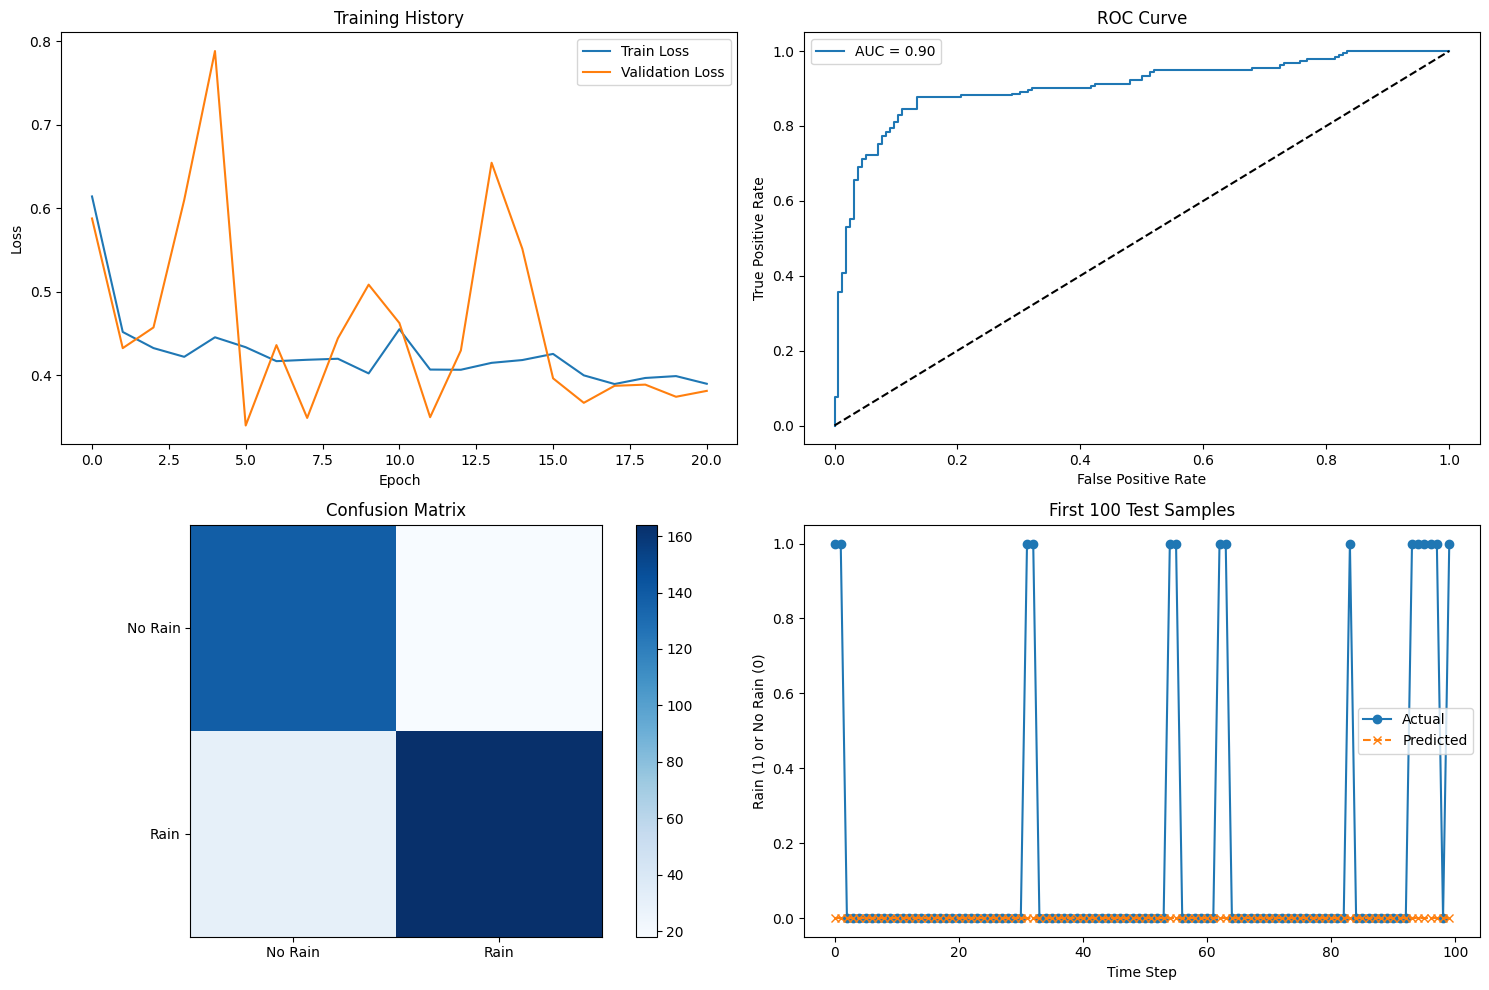


=== 7-Day Rainfall Forecast ===
Day 1: No Rain
Day 2: No Rain
Day 3: No Rain
Day 4: No Rain
Day 5: No Rain
Day 6: No Rain
Day 7: No Rain


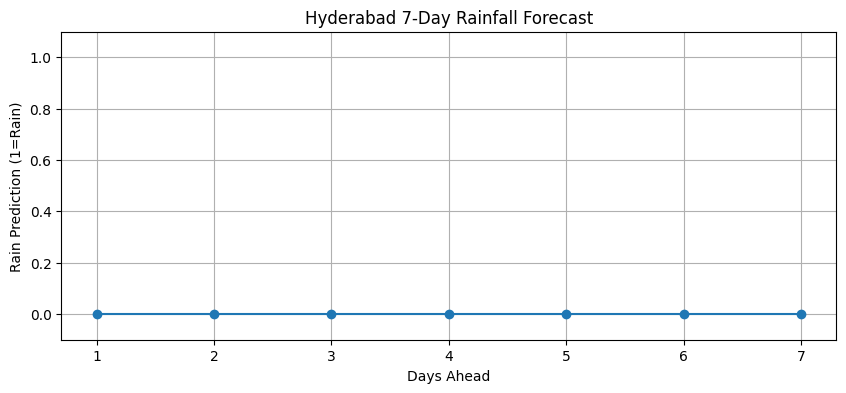

In [1]:
#for rainfaal hyderabad using transformer model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                           accuracy_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape, GlobalAveragePooling1D
# Modified version with enhanced validation checks

def load_and_prepare_data():
    try:
        # Load individual year datasets with explicit year tagging
         df_2019 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2019.csv').assign(YEAR=2019)
         df_2020 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2020.csv').assign(YEAR=2020)
         df_2021 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2021.csv').assign(YEAR=2021)
         df_2022 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2022.csv').assign(YEAR=2022)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading CSV files: {e}")

    # Combine data while preserving year information
    full_df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)
    
    # Data quality checks
    required_cols = ['YEAR', 'MO', 'DY', 'PRECTOTCORR']
    missing_cols = [col for col in required_cols if col not in full_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Convert and clean data
    for col in required_cols:
        full_df[col] = pd.to_numeric(full_df[col], errors='coerce')
    full_df.dropna(subset=required_cols, inplace=True)

    # Create datetime and derived temporal features
    full_df['datetime'] = pd.to_datetime(dict(year=full_df['YEAR'], 
                                            month=full_df['MO'], 
                                            day=full_df['DY']))
    full_df['DOY'] = full_df['datetime'].dt.dayofyear
    full_df['sin_DOY'] = np.sin(2 * np.pi * full_df['DOY'] / 365.25)
    full_df['cos_DOY'] = np.cos(2 * np.pi * full_df['DOY'] / 365.25)

    # Create lagged precipitation features
    for lag in [1, 3, 7]:
        full_df[f'PRECTOTCORR_lag{lag}'] = full_df['PRECTOTCORR'].shift(lag)

    # Calculate Sea Level Temperature (Adilabad elevation: 254m)
    full_df['SLT'] = full_df['TS'] + (0.0065 * 505.5)
    full_df.dropna(inplace=True)

    # Define final feature set
    features = ['SLT', 'SLP', 'T2M', 'TS', 'T2M_MAX', 'T2M_MIN', 
               'RH2M', 'WS10M_MAX', 'WS10M_MIN',
               'sin_DOY', 'cos_DOY', 
               'PRECTOTCORR_lag1', 'PRECTOTCORR_lag3', 'PRECTOTCORR_lag7']
    target = 'PRECTOTCORR'
    full_df['PRECTOTCORR_binary'] = (full_df[target] > 0).astype(int)

    # Strict year-based splitting with validation
    train_years = [2019, 2020, 2021]
    test_year = 2022
    
    train_df = full_df[full_df['YEAR'].isin(train_years)].copy()
    test_df = full_df[full_df['YEAR'] == test_year].copy()
    
    # Additional validation checks
    if len(train_df) == 0:
        raise ValueError("No training data found for specified years")
    if len(test_df) == 0:
        raise ValueError("No test data found for specified year")
    
    # Check for temporal leakage
    max_train_date = train_df['datetime'].max()
    min_test_date = test_df['datetime'].min()
    if min_test_date <= max_train_date:
        raise ValueError(f"Temporal leakage detected! Latest training date ({max_train_date}) is after earliest test date ({min_test_date})")

    # Validate the split
    print("=== Data Partition Validation ===")
    print(f"Training years: {train_years}")
    print(f"Testing year:   {test_year}")
    print(f"\nTraining period: {train_df['datetime'].min().date()} to {train_df['datetime'].max().date()}")
    print(f"Testing period:  {test_df['datetime'].min().date()} to {test_df['datetime'].max().date()}")
    print(f"\nTraining samples: {len(train_df):,}")
    print(f"Testing samples:  {len(test_df):,}")
    print("\nClass distribution (Training):")
    print(train_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    print("\nClass distribution (Testing):")
    print(test_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    
    return train_df, test_df, features, 'PRECTOTCORR_binary'

# Rest of your code remains the same...
# Step 2: Balance and Scale Data
def preprocess_and_balance_data(train_df, test_df, features, target):
    # Initialize scaler and scale features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[features])
    test_scaled = scaler.transform(test_df[features])

    # Apply SMOTE only to training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(train_scaled, train_df[target])
    
    # Create balanced DataFrames
    train_balanced = pd.DataFrame(X_resampled, columns=features)
    train_balanced[target] = y_resampled
    
    test_processed = pd.DataFrame(test_scaled, columns=features, index=test_df.index)
    test_processed[target] = test_df[target]
    test_processed['DOY'] = test_df['DOY']  # Preserve for sequence generation
    
    print("\nAfter SMOTE balancing:")
    print(train_balanced[target].value_counts())
    
    return train_balanced, test_processed, scaler

# Step 3: Create Time Sequences
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Step 4: Build Transformer Model
def build_patchtst_model(seq_len, n_features,
                         patch_size=3,
                         d_model=256,
                         heads=8,
                         ff_dim=512,
                         layers=6):

    inp = Input(shape=(seq_len, n_features))

    # 1. Patchify input
    num_patches = seq_len // patch_size
    x = Reshape((num_patches, patch_size * n_features))(inp)

    # 2. Patch embedding
    x = Dense(d_model)(x)

    # 3. Learnable positional embedding
    pos_emb = tf.Variable(tf.random.normal([1, num_patches, d_model]),
                          trainable=True)
    x = x + pos_emb

    # 4. Transformer Encoder Blocks
    for _ in range(layers):
        attn = MultiHeadAttention(num_heads=heads, key_dim=d_model)(x, x)
        x = Add()([x, attn])
        x = LayerNormalization()(x)

        ffn = Dense(ff_dim, activation="relu")(x)
        ffn = Dense(d_model)(ffn)
        x = Add()([x, ffn])
        x = LayerNormalization()(x)

    # 5. Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # 6. Classification Head
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy",
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall(),
                 tf.keras.metrics.AUC()]
    )

    model.summary()
    return model



# Step 5: Train and Evaluate
def train_and_evaluate(seq_length):
    # Load and prepare data
    train_df, test_df, features, target = load_and_prepare_data()
    
    # Preprocess and balance
    train_balanced, test_processed, scaler = preprocess_and_balance_data(
        train_df, test_df, features, target)
    
    # Create sequences
    X_train, y_train = create_sequences(train_balanced, features, target, seq_length)
    X_test, y_test = create_sequences(test_processed, features, target, seq_length)
    
    print(f"\nFinal input shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

    # Build and train model
    model = build_patchtst_model(seq_length, len(features))
    
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    history = model.fit(X_train, y_train,
                       epochs=200,
                       batch_size=32,
                       validation_split=0.2,
                       callbacks=callbacks,
                       verbose=1)

    # Evaluate on test set
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    print("\n=== Test Set Evaluation ===")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1:        {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_prob):.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot results
    plot_results(history, y_test, y_pred_prob, y_pred)
    
    return model, scaler, test_processed, features, target

def plot_results(history, y_test, y_pred_prob, y_pred):
    plt.figure(figsize=(15, 10))
    
    # Training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # ROC Curve
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # Confusion Matrix
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['No Rain', 'Rain'])
    plt.yticks([0, 1], ['No Rain', 'Rain'])
    
    # Actual vs Predicted
    plt.subplot(2, 2, 4)
    plt.plot(y_test[:100], 'o-', label='Actual')
    plt.plot(y_pred[:100], 'x--', label='Predicted')
    plt.title('First 100 Test Samples')
    plt.xlabel('Time Step')
    plt.ylabel('Rain (1) or No Rain (0)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Step 6: Make Future Predictions
def make_predictions(model, scaler, test_data, features, seq_length, days=7):
    last_sequence = test_data[features].iloc[-seq_length:].values
    predictions = []
    last_doy = test_data['DOY'].iloc[-1]
    
    for _ in range(days):
        x = last_sequence.reshape(1, seq_length, len(features))
        pred_prob = model.predict(x, verbose=0)[0][0]
        pred = 1 if pred_prob > 0.5 else 0
        predictions.append(pred)
        
        # Update sequence with predicted value
        new_row = last_sequence[-1].copy()
        new_row[-3] = pred_prob  # Update lag1 feature
        last_sequence = np.vstack([last_sequence[1:], new_row])
    
    return predictions

if __name__ == "__main__":
    seq_length = 15
    model, scaler, test_data, features, target = train_and_evaluate(seq_length)
    
    # Generate and display forecasts
    forecasts = make_predictions(model, scaler, test_data, features, seq_length)
    print("\n=== 7-Day Rainfall Forecast ===")
    for day, pred in enumerate(forecasts, 1):
        print(f"Day {day}: {'Rain' if pred == 1 else 'No Rain'}")
    
    # Plot forecast
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 8), forecasts, 'o-')
    plt.title('Hyderabad 7-Day Rainfall Forecast')
    plt.xlabel('Days Ahead')
    plt.ylabel('Rain Prediction (1=Rain)')
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.show()
